<a href="https://colab.research.google.com/github/gvidas333/GMM/blob/main/1Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Gvidas Bačianskas
2110532
Naudojamas modelis ResNet 50, klases: Bee, Balloon, Orange

In [4]:
!pip install openimages

Importuojame bibliotekas reikalingas siam projektui. PyTorch naudojamas kaip pagrindinis giliojo mokymosi frameworkas.

In [10]:
import os
from openimages.download import download_dataset
import torch
import torchvision
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


Atsisiunciame 3 klasiu nuotraukas, po 334 nuotraukas klasei.

In [15]:
data_dir = "data"

number_for_samples = 334
classes = ["Bee", "Balloon", "Orange"]

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

print("Downloading is starting...")
download_dataset(data_dir, classes, limit=number_for_samples)

100%|██████████| 334/334 [00:04<00:00, 69.44it/s]


{'bee': {'images_dir': 'data/bee/images'},
 'balloon': {'images_dir': 'data/balloon/images'},
 'orange': {'images_dir': 'data/orange/images'}}

Sukuriama custom data klase, efektyviai paruosiamos ir uzloadinamos nuotraukos.

In [16]:
# Cell 3: Create Custom Dataset Class
class ImageClassificationDataset(Dataset):
    def __init__(self, data_dir, classes, transform=None):
        """Initialize the dataset with root directory and transformation
        Args:
            data_dir (str): Root directory of images
            classes (list): List of class names
            transform: Optional transform to be applied on images
        """
        self.data_dir = data_dir
        self.classes = classes
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # For each class, find all images and add them to our dataset
        for class_idx, class_name in enumerate(classes):
            class_path = os.path.join(data_dir, class_name.lower(), "images")
            # Get all jpg files in the class directory
            class_images = [os.path.join(class_path, f) for f in os.listdir(class_path)
                          if f.endswith('.jpg')]

            self.image_paths.extend(class_images)
            # Add the class index as label for each image
            self.labels.extend([class_idx] * len(class_images))

        print(f"Found {len(self.image_paths)} images total")
        for class_idx, class_name in enumerate(classes):
            class_count = self.labels.count(class_idx)
            print(f"Class {class_name}: {class_count} images")

    def __len__(self):
        """Return the total number of images"""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """Load and return a sample from the dataset
        Args:
            idx (int): Index of the sample to load
        Returns:
            tuple: (image, label) where label is the class index
        """
        # Load image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx]

Transformuojame nuotraukas, kad jos atitiktu istreniruoto modelio reikalavimus.

In [17]:
# Cell 4: Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Standard normalization for ImageNet models
        std=[0.229, 0.224, 0.225]
    )
])

# Create dataset instance
dataset = ImageClassificationDataset(data_dir, classes, transform=transform)

Found 1002 images total
Class Bee: 334 images
Class Balloon: 334 images
Class Orange: 334 images


Naudojame ResNet 50 modeli, jei yra galimybe naudosime GPU.

In [18]:
# Cell 5: Set up pre-trained ResNet50 model
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

# Put model in evaluation mode (not training)
model.eval()

# Move model to GPU if available for faster processing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"Using device: {device}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


Using device: cuda


Padarome, jog nuotrauku pateikimas modeliui butu efektyvus. Tai pasiekiame naudojant dataloaderi, nuotraukas suskirstome i batchus ir jas pramaisome.

In [19]:
# Cell 6: Create DataLoader
batch_size = 32
data_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2  # Number of processes to use for loading data
)

Predictinimo funkcija, kurioje galime keisti slenksti

In [20]:
# Cell 7: Create prediction function with threshold
def predict_with_threshold(model, images, threshold, class_indices):
    """
    Make predictions with a threshold for each class

    Args:
        model: The pre-trained model
        images: Batch of images
        threshold: Classification threshold (between 0 and 1)
        class_indices: Dictionary mapping our classes to model's class indices

    Returns:
        Predictions for each class based on threshold
    """
    # Move images to same device as model
    images = images.to(device)

    # Get model predictions
    with torch.no_grad():  # We don't need gradients for prediction
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)

    # Initialize predictions dictionary
    predictions = {}

    # For each of our classes
    for class_name, idx in class_indices.items():
        # Get probability for this class
        class_probs = probabilities[:, idx]
        # Apply threshold
        predictions[class_name] = (class_probs > threshold).cpu()

    return predictions

# Get the indices of our classes in the pre-trained model's class list
class_indices = {
    class_name: weights.meta["categories"].index(class_name.lower())
    for class_name in classes
}

print("Class indices in the pre-trained model:")
for class_name, idx in class_indices.items():
    print(f"{class_name}: {idx}")

Class indices in the pre-trained model:
Bee: 309
Balloon: 417
Orange: 950


Sukuriame funkcija, kuri parodytu metrics kaip sekasi modeliui.

In [21]:
# Cell 8: Create functions for calculating metrics
def calculate_metrics(true_labels, predictions):
    """
    Calculate accuracy, precision, recall, and F1 score

    Args:
        true_labels: The actual labels (ground truth)
        predictions: Model predictions after applying threshold

    Returns:
        Dictionary containing all metrics
    """
    # Convert tensors to numpy for easier calculation
    predictions = predictions.numpy()
    true_labels = true_labels.numpy()

    # Calculate True Positives, False Positives, False Negatives
    true_positives = np.sum((predictions == 1) & (true_labels == 1))
    false_positives = np.sum((predictions == 1) & (true_labels == 0))
    false_negatives = np.sum((predictions == 0) & (true_labels == 1))
    true_negatives = np.sum((predictions == 0) & (true_labels == 0))

    # Calculate metrics
    accuracy = (true_positives + true_negatives) / len(true_labels)

    # Handle division by zero cases
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

Si funkcija apjungia visas pries tai apibreztas funkcijas, nuotraukos pereina modeli, pritaikomas slenkstis ir paskaiciuojamos reiksmes.

In [24]:
# Cell 9: Create function to evaluate model with different thresholds
def evaluate_model(model, data_loader, threshold, class_indices):
    """
    Evaluate model performance with a specific threshold

    Args:
        model: The pre-trained model
        data_loader: DataLoader with our dataset
        threshold: Classification threshold value
        class_indices: Dictionary mapping our classes to model indices

    Returns:
        Dictionary with metrics for each class
    """
    all_metrics = {}

    # For storing predictions and labels
    class_predictions = {class_name: [] for class_name in classes}
    class_labels = {class_name: [] for class_name in classes}

    # Process all batches
    for images, batch_labels in data_loader:
        # Get predictions with current threshold
        predictions = predict_with_threshold(model, images, threshold, class_indices)

        # Store predictions and labels for each class
        for class_idx, class_name in enumerate(classes):
            class_pred = predictions[class_name]
            class_true = (batch_labels == class_idx).cpu()

            class_predictions[class_name].append(class_pred)
            class_labels[class_name].append(class_true)

    # Calculate metrics for each class
    for class_name in classes:
        # Concatenate all predictions and labels for this class
        all_preds = torch.cat(class_predictions[class_name])
        all_labels = torch.cat(class_labels[class_name])

        # Calculate metrics
        metrics = calculate_metrics(all_labels, all_preds)
        all_metrics[class_name] = metrics

    return all_metrics

In [33]:
# Cell 10: Create function to display results
def display_results(metrics):
    """
    Display evaluation metrics in a readable format
    """
    for class_name, class_metrics in metrics.items():
        print(f"\n{class_name} Class Metrics:")
        print("-" * 20)
        for metric_name, value in class_metrics.items():
            print(f"{metric_name.capitalize()}: {value:.3f}")

In [29]:
# Cell 11: Test everything with a sample threshold
threshold = 0.5  # We can adjust this value between 0 and 1
print(f"Evaluating model with threshold = {threshold}")
metrics = evaluate_model(model, data_loader, threshold, class_indices)
display_results(metrics)

Evaluating model with threshold = 0.5

Bee Class Metrics:
--------------------
Accuracy: 0.701
Precision: 1.000
Recall: 0.102
F1: 0.185

Balloon Class Metrics:
--------------------
Accuracy: 0.744
Precision: 1.000
Recall: 0.231
F1: 0.375

Orange Class Metrics:
--------------------
Accuracy: 0.697
Precision: 1.000
Recall: 0.090
F1: 0.165


In [31]:
# Cell 12: Create visualization of metrics across thresholds
import numpy as np

def evaluate_thresholds(model, data_loader, class_indices, num_points=20):
    """
    Evaluate model performance across different thresholds

    Args:
        model: The pre-trained model
        data_loader: DataLoader with our dataset
        class_indices: Dictionary mapping our classes to model indices
        num_points: Number of threshold points to evaluate

    Returns:
        Dictionary containing threshold values and corresponding metrics
    """
    # Create threshold values from 0 to 1
    thresholds = np.linspace(0, 1, num_points)

    # Store results for each class
    results = {class_name: {
        'thresholds': thresholds,
        'precision': [],
        'recall': [],
        'f1': []
    } for class_name in classes}

    # Evaluate each threshold
    for threshold in thresholds:
        metrics = evaluate_model(model, data_loader, threshold, class_indices)

        # Store metrics for each class
        for class_name in classes:
            results[class_name]['precision'].append(metrics[class_name]['precision'])
            results[class_name]['recall'].append(metrics[class_name]['recall'])
            results[class_name]['f1'].append(metrics[class_name]['f1'])

    return results

Evaluating model across different thresholds...


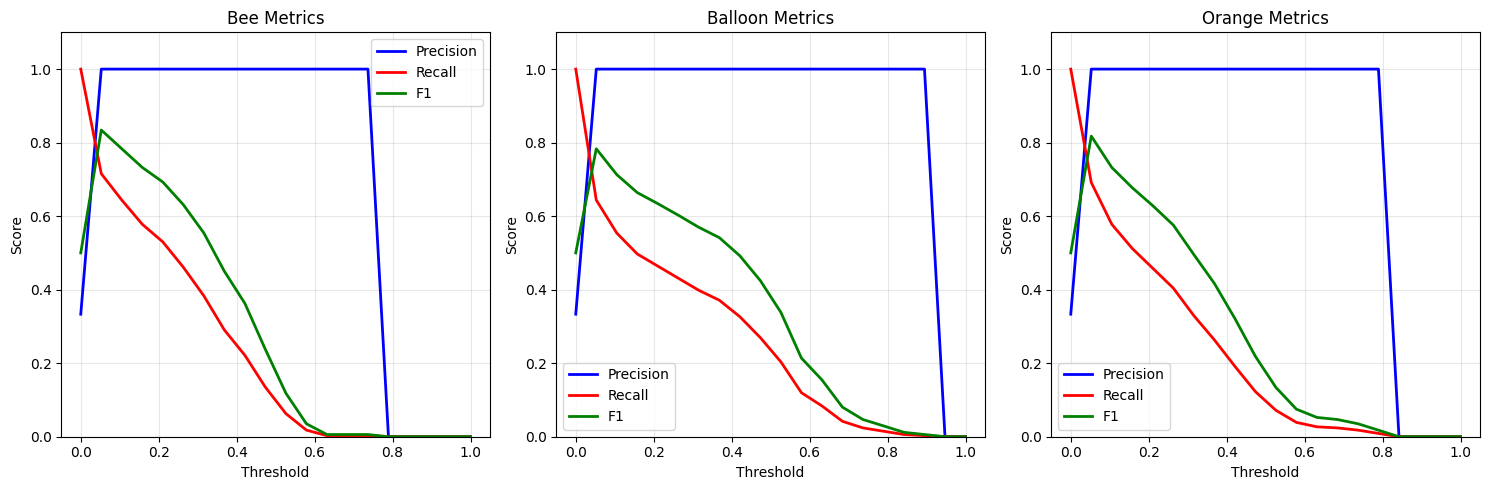

In [32]:
# Cell 13: Create and display the plots
def plot_metrics(results):
    """
    Create plots showing how metrics change with threshold
    """
    # Create a figure with subplots for each class
    fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))

    # Colors for different metrics
    colors = {'precision': 'blue', 'recall': 'red', 'f1': 'green'}

    # Plot for each class
    for idx, class_name in enumerate(classes):
        ax = axes[idx]
        class_results = results[class_name]

        # Plot each metric
        for metric in ['precision', 'recall', 'f1']:
            ax.plot(class_results['thresholds'],
                   class_results[metric],
                   color=colors[metric],
                   label=metric.capitalize(),
                   linewidth=2)

        # Customize the plot
        ax.set_title(f'{class_name} Metrics')
        ax.set_xlabel('Threshold')
        ax.set_ylabel('Score')
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.set_ylim(0, 1.1)

    plt.tight_layout()
    plt.show()

# Run the evaluation and create the plots
print("Evaluating model across different thresholds...")
results = evaluate_thresholds(model, data_loader, class_indices)
plot_metrics(results)